### Weatherstack Free Plan doesnt support historical time series querying

# D - Dataset Preparation

In [184]:
import datetime
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# E - Exploration begins 

In [185]:
hdf = pd.read_excel("E:\Work II\DS\Documents\Python\Projects\Temperature Forecasting\historical_dfx.xlsx")

In [186]:
for d in hdf['Dates']:
    d = datetime.datetime.strptime("2021-01-02", '%Y-%m-%d')

In [187]:
x = hdf['Dates']
yh = np.array(hdf['Temp_High'])
yl = np.array(hdf['Temp_Low'])

### Superimposed Temp_High & Temp_Low Plots

Text(0, 0.5, 'Temp_High')

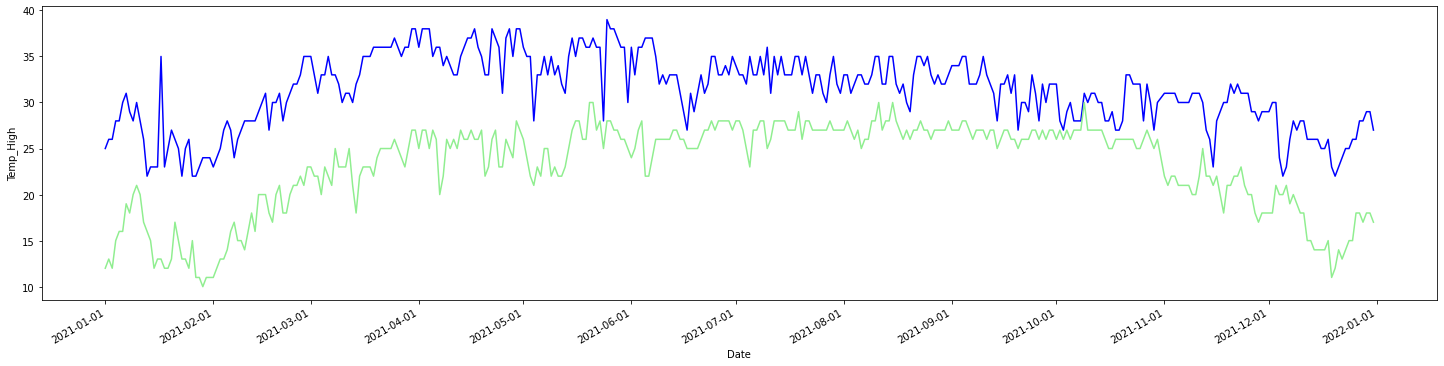

In [188]:
fig, ax = plt.subplots(figsize=(25, 6))


formatter = mdates.DateFormatter("%Y-%m-%d")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(locator)

ax.plot(x, yh, label='Temperature_High', color = 'blue')
ax.plot(x, yl, label='Temperature_Low', color = 'lightgreen')

plt.xlabel('Date')
plt.ylabel('Temp_High')


# ------TH------


### Preparing the data for Temp_High

In [189]:
FullHighData=hdf[['Temp_High']].values
len(FullHighData)

364

In [190]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()

DataScaler = sc.fit(FullHighData)
XHigh=DataScaler.transform(FullHighData)

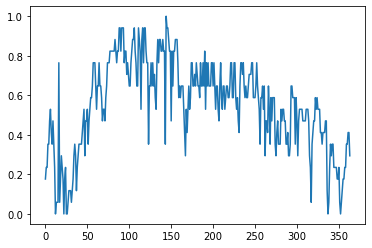

In [191]:
plt.plot(XHigh)

In [192]:
XHigh_samples = list()
yHigh_samples = list()

nRows = len(XHigh)
TimeSteps=10  # next day's Temp_High Prediction is based on last how many past day's Temp_Highs

# Iterate thru the values to create combinations
for i in range(TimeSteps , nRows , 1):
    xh_sample = XHigh[i-TimeSteps:i]
    
    yh_sample = XHigh[i]
    
    XHigh_samples.append(xh_sample)
    yHigh_samples.append(yh_sample)

### 3D Reshaping

In [193]:
XHigh_data=np.array(XHigh_samples)
XHigh_data=XHigh_data.reshape(XHigh_data.shape[0],XHigh_data.shape[1], 1)
XHigh_data.shape

(354, 10, 1)

In [194]:
yHigh_data=np.array(yHigh_samples)
yHigh_data=yHigh_data.reshape(yHigh_data.shape[0], 1)
yHigh_data.shape

(354, 1)

### Testing

In [195]:
TestingRecords=5

# Splitting the data into train and test
XHigh_train=XHigh_data[:-TestingRecords]
XHigh_test=XHigh_data[-TestingRecords:]
yHigh_train=yHigh_data[:-TestingRecords]
yHigh_test=yHigh_data[-TestingRecords:]

In [196]:
# Defining Input shapes for LSTM

TimeSteps=XHigh_train.shape[1]
TotalFeatures=XHigh_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


### Fitting the Deep Learning LSTM model

In [197]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressorH = Sequential()

# Adding the First input hidden layer and the LSTM layer
regressorH.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressorH.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressorH.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressorH.add(Dense(units = 1))

# Compiling the RNN
regressorH.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [198]:
StartTime=time.time()

# Fitting the RNN to the Training set
regressorH.fit(XHigh_train, yHigh_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')

Epoch 1/100
70/70 [==============================] - 4s 5ms/step - loss: 0.2966
Epoch 2/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0306
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0235
Epoch 4/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0193
Epoch 5/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0216
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 7/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0191
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0216
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0206
Epoch 10/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 11/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 12/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0201
Epoch 13/100
70/70 [=================

### Generating predictions on testing data

In [199]:
predicted_temp_high = regressorH.predict(XHigh_test)
predicted_temp_high = DataScaler.inverse_transform(predicted_temp_high)
predicted_temp_high

array([[25.848902],
       [26.82498 ],
       [27.345   ],
       [28.168074],
       [28.631199]], dtype=float32)

In [200]:
# Getting the original Temp_High values for testing data
origHigh=yHigh_test
origHigh=DataScaler.inverse_transform(yHigh_test)
origHigh

array([[28.],
       [28.],
       [29.],
       [29.],
       [27.]])

### Measuring the Accuracy of predictions

In [201]:
# Accuracy of the predictions
100 - (100*(abs(origHigh-predicted_temp_high)/origHigh)).mean()

94.70078353311128

### Visualising the results

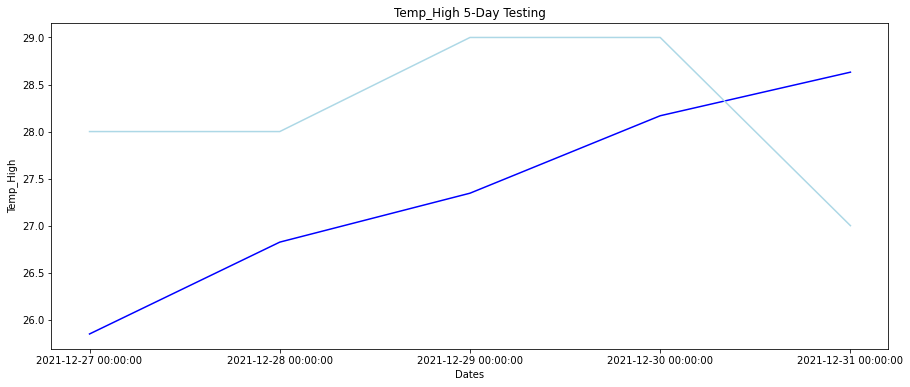

In [202]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(predicted_temp_high, label='Predicted Temperature_High', color = 'blue')
ax.plot(origHigh, label='Original Temp_High', color = 'lightblue')

plt.title('Temp_High 5-Day Testing')
plt.xticks(range(TestingRecords), hdf.tail(TestingRecords)['Dates'])
plt.xlabel('Dates')
plt.ylabel('Temp_High')

fig.set_figwidth(15)
fig.set_figheight(6)
plt.show()



### Plotting the predictions for full data

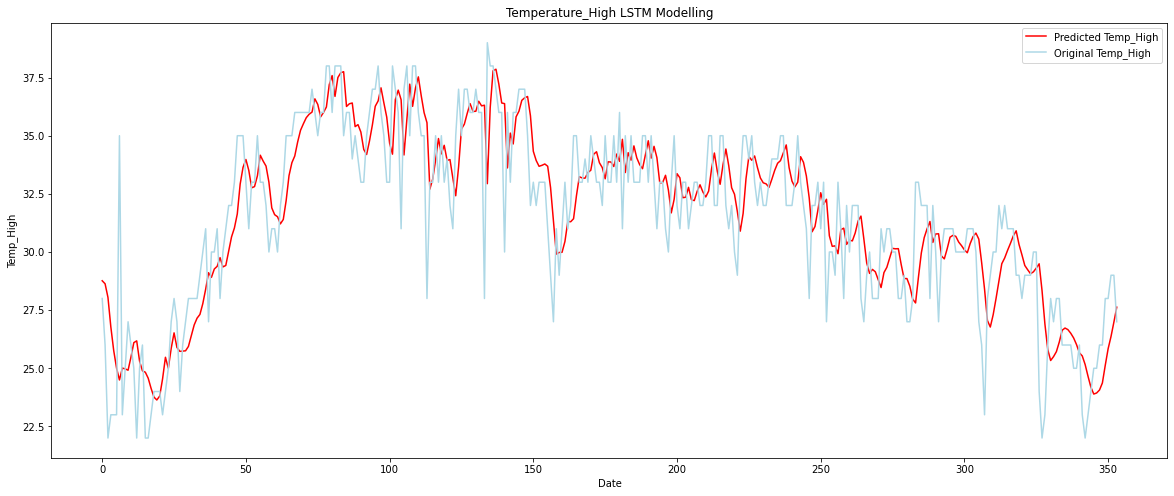

In [203]:
# Generating predictions on full data
TrainHighPredictions=DataScaler.inverse_transform(regressor.predict(XHigh_train))
TestHighPredictions=DataScaler.inverse_transform(regressor.predict(XHigh_test))

FullDataHighPredictions=np.append(TrainHighPredictions, TestHighPredictions)
FullDataHighOrig=FullHighData[TimeSteps:]

# plotting the full data
plt.plot(FullDataHighPredictions, color = 'red', label = 'Predicted Temp_High')
plt.plot(FullDataHighOrig , color = 'lightblue', label = 'Original Temp_High')


plt.title('Temperature_High LSTM Modelling')
plt.xlabel('Date')
plt.ylabel('Temp_High')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

In [204]:
date_1 = datetime.datetime.strptime('2021-12-31', "%Y-%m-%d")

end_date = date_1 + datetime.timedelta(days=1)
ed = end_date.strftime('%Y-%m-%d')
print(ed)

2022-01-01


In [205]:
Last10Days=np.array(FullData[-10:])
 
# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
#############################
 
# Making predictions on data
predicted_Temp_High = regressor.predict(Last10Days)
predicted_Temp_High = DataScaler.inverse_transform(predicted_Temp_High)
print('The predicted high temperature for {} is {}'.format(ed, str(predicted_Temp_High).replace('[',"").replace(']',"")))
th_forecast = 'The predicted high temperature for {} is {}'.format(ed, str(predicted_Temp_High).replace('[',"").replace(']',""))

The predicted high temperature for 2022-01-01 is 27.05688


# ------TL------

### Preparing the data for Temp_Low

In [206]:
FullDataLow=hdf[['Temp_Low']].values
len(FullDataLow)

364

In [207]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()

DataScaler = sc.fit(FullDataLow)
XLow=DataScaler.transform(FullDataLow)

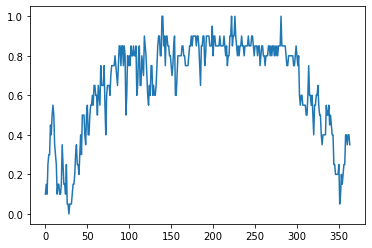

In [208]:
plt.plot(XLow)

In [209]:
XLow_samples = list()
yLow_samples = list()

nRows = len(XLow)
TimeSteps=10  # next day's Temp_Low Prediction is based on last how many past day's Temp_Lows

# Iterate thru the values to create combinations
for i in range(TimeSteps , nRows , 1):
    xl_sample = XLow[i-TimeSteps:i]
    
    yl_sample = XLow[i]
    
    XLow_samples.append(xl_sample)
    yLow_samples.append(yl_sample)

### 3D Reshaping

In [210]:
XLow_data=np.array(XLow_samples)
XLow_data=XLow_data.reshape(XLow_data.shape[0],XLow_data.shape[1], 1)
XLow_data.shape

(354, 10, 1)

In [211]:
yLow_data=np.array(yLow_samples)
yLow_data=yLow_data.reshape(yLow_data.shape[0], 1)
yLow_data.shape

(354, 1)

### Testing

In [212]:
TestingRecords=5

# Splitting the data into train and test
XLow_train=XLow_data[:-TestingRecords]
XLow_test=XLow_data[-TestingRecords:]
yLow_train=yLow_data[:-TestingRecords]
yLow_test=yLow_data[-TestingRecords:]

In [213]:
# Defining Input shapes for LSTM

TimeSteps=XLow_train.shape[1]
TotalFeatures=XLow_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


### Fitting the Deep Learning LSTM model

In [214]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressorL = Sequential()

# Adding the First input hidden layer and the LSTM layer
regressorL.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressorL.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressorL.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressorL.add(Dense(units = 1))

# Compiling the RNN
regressorL.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [215]:
StartTime=time.time()

# Fitting the RNN to the Training set
regressorL.fit(XLow_train, yLow_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')

Epoch 1/100
70/70 [==============================] - 4s 5ms/step - loss: 0.3943
Epoch 2/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0139
Epoch 4/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0138
Epoch 5/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0136
Epoch 7/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0131
Epoch 10/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 11/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 12/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0112
Epoch 13/100
70/70 [=================

### Generating predictions on testing data

In [216]:
predicted_temp_low = regressorL.predict(XLow_test)
predicted_temp_low = DataScaler.inverse_transform(predicted_temp_low)
predicted_temp_low

array([[17.488504],
       [17.815777],
       [17.451479],
       [17.984226],
       [17.821611]], dtype=float32)

In [217]:
# Getting the original Temp_Low values for testing data
origLow=yLow_test
origLow=DataScaler.inverse_transform(yLow_test)
origLow

array([[18.],
       [17.],
       [18.],
       [18.],
       [17.]])

### Measuring the Accuracy of predictions

In [218]:
# Accuracy of the predictions
100 - (100*(abs(origLow-predicted_temp_low)/origLow)).mean()

96.87833823409736

### Visualising the results

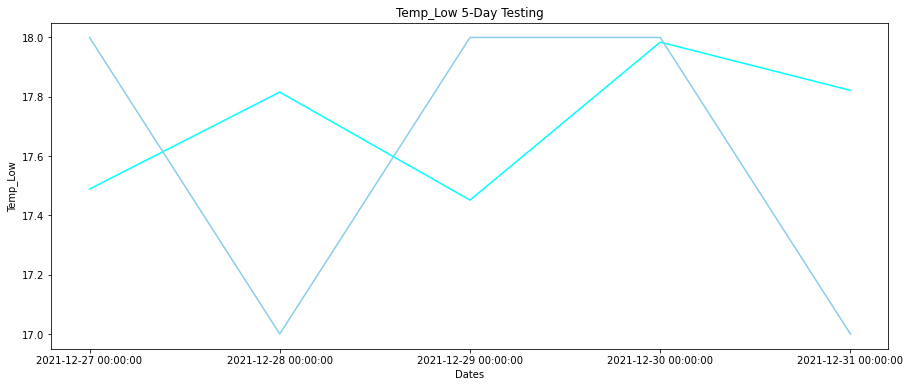

In [219]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(predicted_temp_low, label='Predicted Temperature_Low', color = 'cyan')
ax.plot(orig, label='Original Temp_Low', color = 'skyblue')

plt.title('Temp_Low 5-Day Testing')
plt.xticks(range(TestingRecords), hdf.tail(TestingRecords)['Dates'])
plt.xlabel('Dates')
plt.ylabel('Temp_Low')

fig.set_figwidth(15)
fig.set_figheight(6)
plt.show()



### Plotting the predictions for full data

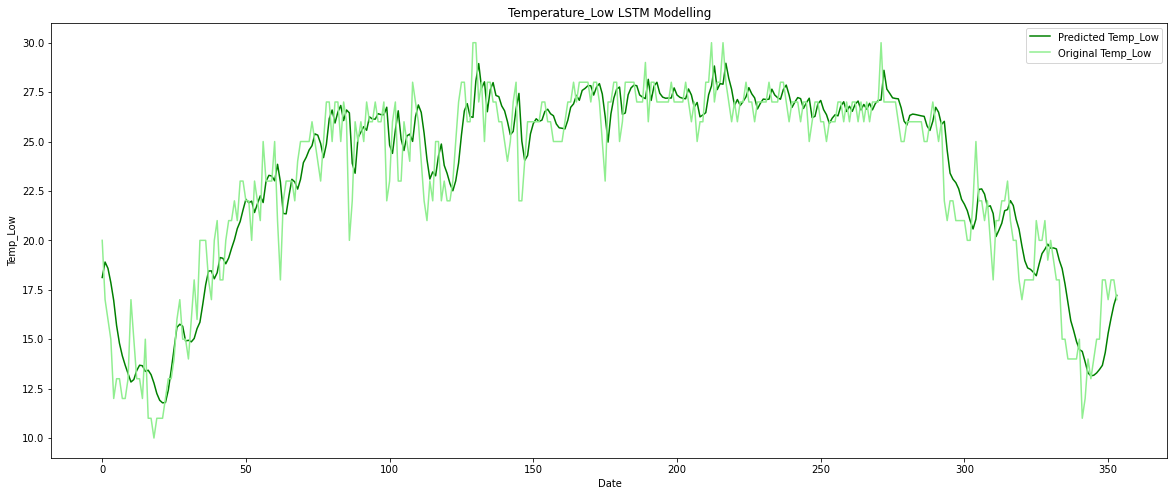

In [220]:
# Generating predictions on full data
TrainLowPredictions=DataScaler.inverse_transform(regressor.predict(XLow_train))
TestLowPredictions=DataScaler.inverse_transform(regressor.predict(XLow_test))

FullDataLowPredictions=np.append(TrainLowPredictions, TestLowPredictions)
FullDataLowOrig=FullDataLow[TimeSteps:]

# plotting the full data
plt.plot(FullDataLowPredictions, color = 'green', label = 'Predicted Temp_Low')
plt.plot(FullDataLowOrig , color = 'lightgreen', label = 'Original Temp_Low')


plt.title('Temperature_Low LSTM Modelling')
plt.xlabel('Date')
plt.ylabel('Temp_Low')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

In [221]:
date_1 = datetime.datetime.strptime('2021-12-31', "%Y-%m-%d")

end_date = date_1 + datetime.timedelta(days=1)
ed = end_date.strftime('%Y-%m-%d')
print(ed)

2022-01-01


In [222]:
Last10Days=np.array(FullData[-10:])
 
# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
#############################
 
# Making predictions on data
predicted_Temp_Low = regressor.predict(Last10Days)
predicted_Temp_Low = DataScaler.inverse_transform(predicted_Temp_Low)
print('The predicted low temperature for {} is {}'.format(ed, str(predicted_Temp_Low).replace('[',"").replace(']',"")))
tl_forecast = 'The predicted low temperature for {} is {}'.format(ed, str(predicted_Temp_Low).replace('[',"").replace(']',""))

The predicted low temperature for 2022-01-01 is 17.172726


# Forecast

In [223]:
print(th_forecast)
print(tl_forecast)

The predicted high temperature for 2022-01-01 is 27.05688
The predicted low temperature for 2022-01-01 is 17.172726
